# We are going to perform classification task on 20 newsgroup data, on C and S subcategories using the following algorithms:
C and S contain the following subcategories: ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']
1. SVM from LibSVM
2. Logistic Reegression
3. Random Forest
4. Simple Model Averaging (SMA)
5. LS-SVM
6. pLWE (Partial Locally Weighted Ensemble)- which is just LWE without structure based adjustment step.
7. LWE (Locally Weighted Ensemble)

In [78]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelBinarizer
from sklearn.calibration import CalibratedClassifierCV  # For probability calibration
import numpy as np
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA




In [79]:

# Define the groups for training and testing
training_set = ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics']
testing_set = [ 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']

# Fetch the newsgroups data for training and testing
newsgroups_train = fetch_20newsgroups(subset='train', categories=training_set)
newsgroups_test = fetch_20newsgroups(subset='test', categories=testing_set)

# Convert the text data into vectors using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
vectors_train = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)  # Use transform instead of fit_transform for the test set

# Apply PCA to reduce dimensionality to 50
pca = PCA(n_components=50, random_state=42)
train_pca = pca.fit_transform(vectors_train.toarray())  # Convert sparse matrix to dense array for PCA
test_pca = pca.transform(vectors_test.toarray())        # Convert sparse matrix to dense array for PCA


# visualizing the dataset, four different colors represent four different subcategories in C and S categories.

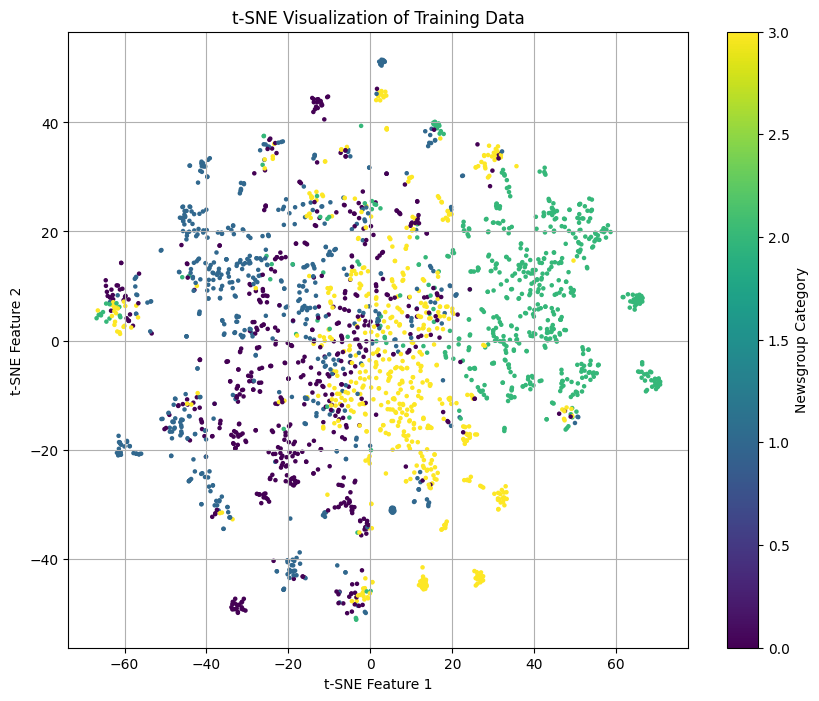

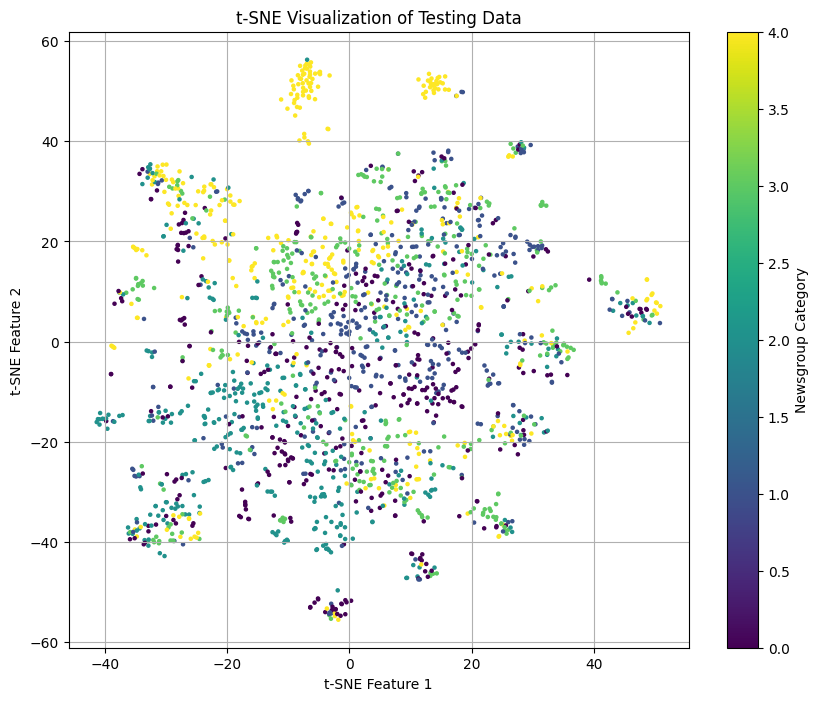

In [82]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the PCA-reduced data for both training and testing
# sets.t-SNE [1] is a tool to visualize high-dimensional data. It converts
# similarities between data points to joint probabilities and tries to minimize
# the Kullback-Leibler divergence between the joint probabilities of the low-dimensional
# embedding and the high-dimensional data. t-SNE has a cost function that is
#not convex, i.e. with different initializations we can get different results.
tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_pca)
test_tsne = tsne.fit_transform(test_pca)

# Plot the training data
plt.figure(figsize=(10, 8))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=newsgroups_train.target, cmap='viridis', s=5)
plt.title('t-SNE Visualization of Training Data')
plt.colorbar(label='Newsgroup Category')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.grid(True)
plt.show()

# Plot the testing data
plt.figure(figsize=(10, 8))
plt.scatter(test_tsne[:, 0], test_tsne[:, 1], c=newsgroups_test.target, cmap='viridis', s=5)
plt.title('t-SNE Visualization of Testing Data')
plt.colorbar(label='Newsgroup Category')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.grid(True)
plt.show()


In [81]:
import numpy as np

# Define categories
categories = ['sci.crypt', 'sci.electronics', 'comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x',
              'sci.med', 'sci.space']

# Count data points in training set
train_category_counts = {category: np.sum(np.array(newsgroups_train.target) == newsgroups_train.target_names.index(category))
                         for category in training_set}

# Count data points in testing set
test_category_counts = {category: np.sum(np.array(newsgroups_test.target) == newsgroups_test.target_names.index(category))
                        for category in testing_set}

# Print results
print("Training set:")
for category, count in train_category_counts.items():
    print(f"{category}: {count} data points")

print("\nTesting set:")
for category, count in test_category_counts.items():
    print(f"{category}: {count} data points")


Training set:
comp.graphics: 584 data points
comp.os.ms-windows.misc: 591 data points
sci.crypt: 595 data points
sci.electronics: 591 data points

Testing set:
comp.sys.ibm.pc.hardware: 392 data points
comp.sys.mac.hardware: 385 data points
comp.windows.x: 395 data points
sci.med: 396 data points
sci.space: 394 data points


# Implementing SVM, Logistic Regression and Random Forest Algorithm in order to use them as base models.

---



# As mentioned in alloted research paper we will be using the SVM implemented in Libsvm as one of the base model for the ensemble.
# Implementing SVM from LibSVM
Reference:

https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


In [4]:


# Define the categories for training and testing
train_categories = ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics']
test_categories = [ 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']


# Fetch the training and testing datasets
data_train = fetch_20newsgroups(subset='train', categories=train_categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test', categories=test_categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

# Map the target names to the categories R and T
category_mapping = {'comp.graphics':'C','comp.os.ms-windows.misc':'C','sci.crypt':'S','sci.electronics':'S',
                    'comp.sys.ibm.pc.hardware':'C','comp.sys.mac.hardware':'C','comp.windows.x':'C','sci.med':'S','sci.space':'S'}
data_train.target = [category_mapping[data_train.target_names[i]] for i in data_train.target]
data_test.target = [category_mapping[data_test.target_names[i]] for i in data_test.target]
print("data_train.target_names",data_train.target_names)
print("data_test.target_names", data_test.target_names)
print("data_train.target", data_train.target)
#print(data_train.target).shape)
print("data_test.target",data_test.target)
#print(data_test.target.shape)




data_train.target_names ['comp.graphics', 'comp.os.ms-windows.misc', 'sci.crypt', 'sci.electronics']
data_test.target_names ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'sci.med', 'sci.space']
data_train.target ['C', 'C', 'S', 'C', 'S', 'C', 'S', 'S', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'C', 'S', 'C', 'S', 'S', 'C', 'C', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'S', 'C', 'S', 'S', 'S', 'C', 'S', 'S', 'C', 'S', 'C', 'S', 'C', 'S', 'S', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'S', 'C', 'S', 'C', 'C', 'S', 'C', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'C', 'S', 'C', 'S', 'C', 'C', 'S', 'C', 'C', 'S', 'S', 'C', 'S', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'S', 'S', 'C', 'C', 'C', 'C', 'S', 'S', 'C', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'S', 'S', 'C', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'C', 'S', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'C', 'C', 'S', 'C', 'S', 'S', 'C', 'C', 'S', 'C', 'C', 'S', 'C', '

# here in the pipeline we are using SVM from LibSVM which is also called as  C-Support Vector Classification, (SVC) the implementation of which is based on LibSVM.
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

1. The first step is named 'vect', which represents a TfidfVectorizer. TfidfVectorizer is used to convert a collection of raw documents to a matrix of TF-IDF features (Term Frequency-Inverse Document Frequency).
2. The second step is named 'clf', which will represent one of three classifiers we will be using for classification tasks.
3. The parameter probability=True indicates that the SVC should be able to compute class probabilities.

In [5]:
# Define the pipeline with a TfidfVectorizer and SVC
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SVC(probability=True)),
])


1. parameter_grid is a dictionary containing hyperparameters and their corresponding values.

2. These hyperparameters are used during the hyperparameter tuning process performed by RandomizedSearchCV.
3. vect__max_df, vect__min_df, vect__ngram_range, and vect__norm are hyperparameters for the TfidfVectorizer.


4. clf__C, clf__gamma, and clf__kernel are hyperparameters for the classifier.


5. The values assigned to these hyperparameters are the different options that RandomizedSearchCV will explore during the search process to find the best combination of hyperparameters for the pipeline.

In [6]:
# Define the parameter grid for the RandomizedSearchCV
parameter_grid = {
    'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
    'vect__min_df': (1, 3, 5, 10),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__norm': ('l1', 'l2'),
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'clf__kernel': ['linear', 'rbf'],
}




In [7]:
# Perform the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameter_grid, n_iter=5, random_state=0, n_jobs=2, verbose=1)
print("Performing grid search...")
t0 = time()
random_search.fit(data_train.data, data_train.target)
print(f"Done in {time() - t0:.3f}s")


Performing grid search...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Done in 283.011s


In [8]:
# Print the best parameters
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")


Best parameters combination found:
clf__C: 1
clf__gamma: 1
clf__kernel: linear
vect__max_df: 0.6
vect__min_df: 1
vect__ngram_range: (1, 2)
vect__norm: l2


# Calculating probabilities for test samples.

In [9]:
# Print the probabilities
probabilities1 = random_search.predict_proba(data_test.data)
print(" SVM Probabilities:", probabilities1)
print(probabilities1.shape)

 SVM Probabilities: [[6.31166038e-02 9.36883396e-01]
 [9.93725883e-01 6.27411690e-03]
 [9.35601810e-01 6.43981905e-02]
 ...
 [1.36173474e-05 9.99986383e-01]
 [5.00573615e-07 9.99999499e-01]
 [9.84129579e-01 1.58704215e-02]]
(1962, 2)


# calculating predictions

In [10]:
# Predict the categories
predictions1 = random_search.predict(data_test.data)

# Print the predictions
print("Predictions1:", predictions1)



Predictions1: ['S' 'C' 'C' ... 'S' 'S' 'C']


# Accuracy and MSE

In [11]:

# Evaluate the model on the test set
test_accuracy = random_search.score(data_test.data, data_test.target)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy on test set: 0.736


In [12]:
# Print the mean squared error
# First, we need to convert the target labels to numeric values
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
numeric_test_target = le.fit_transform(data_test.target)
numeric_predictions = le.transform(random_search.predict(data_test.data))
mse = mean_squared_error(numeric_test_target, numeric_predictions)
print(f"Mean Squared Error: {mse:.3f}")


Mean Squared Error: 0.264


# *The accuracy and MSE for the SVM algo for "C vs S" classification have come out to be .736 and 0.264 which are comparable to the Accuracy and MSE in research paper that is 0.7118 and 0.2140 respectively.*

# Precision, recall and F score

In [13]:
from sklearn.metrics import classification_report

# Calculate and print the precision, recall, and F1-score
predictions = random_search.predict(data_test.data)
report = classification_report(data_test.target, predictions)
print("Classification report:")
print(report)


Classification report:
              precision    recall  f1-score   support

           C       0.83      0.70      0.76      1172
           S       0.64      0.79      0.71       790

    accuracy                           0.74      1962
   macro avg       0.74      0.74      0.73      1962
weighted avg       0.75      0.74      0.74      1962



precision, recall and f1 score reflect average performance of the SVM model however in the research paper the researchers have not mentioned precision, f1 score and recall so its not possible to directly compare.

# Confusion Matrix

In [14]:
svm_model=random_search

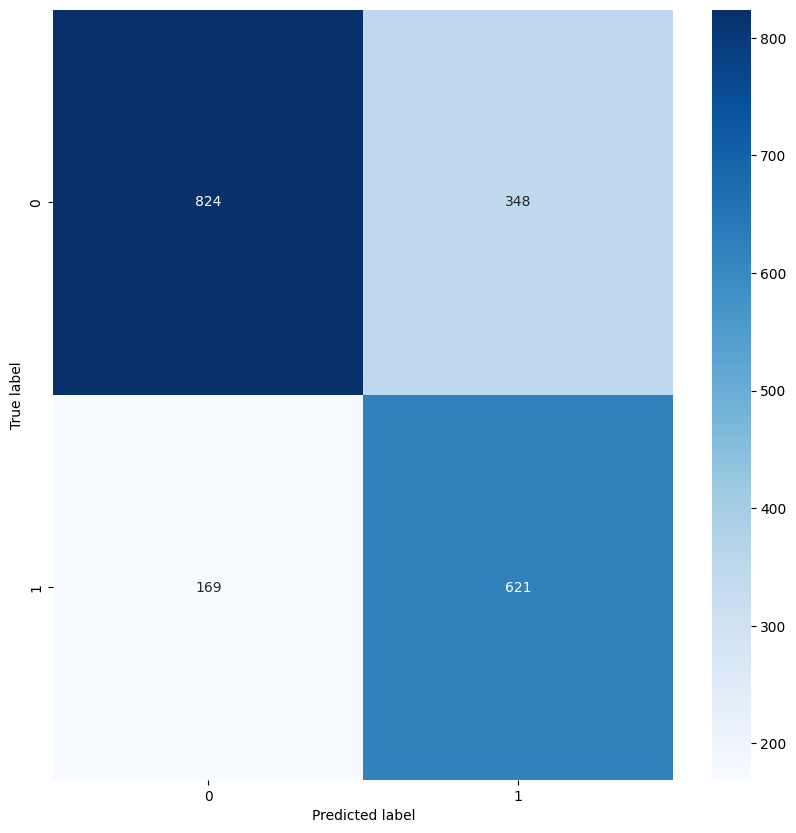

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(data_test.target, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()


# Logistic Regression:

---
In the research paper, the authors have mentioned Logistic Regression from BBR package however since the code for the same was not available, after consulting with Prof. P Balamurugan Logistic Regression from scikit learn was implemented.


Implementing Logistic Regression from Scikit learn on 20 newsgroup dataset:
Reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_20newsgroups.html

In [16]:


# Define the categories for training and testing
training_categories = ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics']
testing_categories = [ 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']

# Fetch the training and testing data
data_train = fetch_20newsgroups(subset='train', categories=train_categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test', categories=test_categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))


# Map the target names to the categories R and T
category_mapping = {'comp.graphics':'C','comp.os.ms-windows.misc':'C','sci.crypt':'S','sci.electronics':'S',
                    'comp.sys.ibm.pc.hardware':'C','comp.sys.mac.hardware':'C','comp.windows.x':'C','sci.med':'S','sci.space':'S'}
data_train.target = [category_mapping[data_train.target_names[i]] for i in data_train.target]
data_test.target = [category_mapping[data_test.target_names[i]] for i in data_test.target]
print("data_train.target_names",data_train.target_names)
print("data_test.target_names", data_test.target_names)
print("data_train.target", data_train.target)
#print(data_train.target).shape)
print("data_test.target",data_test.target)
#print(data_test.target.shape)





data_train.target_names ['comp.graphics', 'comp.os.ms-windows.misc', 'sci.crypt', 'sci.electronics']
data_test.target_names ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'sci.med', 'sci.space']
data_train.target ['C', 'C', 'S', 'C', 'S', 'C', 'S', 'S', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'C', 'S', 'C', 'S', 'S', 'C', 'C', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'S', 'C', 'S', 'S', 'S', 'C', 'S', 'S', 'C', 'S', 'C', 'S', 'C', 'S', 'S', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'S', 'C', 'S', 'C', 'C', 'S', 'C', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'C', 'S', 'C', 'S', 'C', 'C', 'S', 'C', 'C', 'S', 'S', 'C', 'S', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'S', 'S', 'C', 'C', 'C', 'C', 'S', 'S', 'C', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'S', 'S', 'C', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'C', 'C', 'C', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'C', 'S', 'C', 'S', 'C', 'C', 'C', 'C', 'S', 'C', 'C', 'S', 'C', 'S', 'S', 'C', 'C', 'S', 'C', 'C', 'S', 'C', '

Here 'clf', which represents a LogisticRegression classifier is being used for binary classification tasks as we only have two target categories.

In [17]:
# Define the pipeline with a TfidfVectorizer and LogisticRegression
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression()),
])

# Define the parameter grid for the RandomizedSearchCV
parameter_grid = {
    'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
    'vect__min_df': (1, 3, 5, 10),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__norm': ('l1', 'l2'),
    'clf__C': np.logspace(-4, 4, 20),
    'clf__penalty': ['l1', 'l2'],
}

In [18]:

# Define the pipeline with a TfidfVectorizer and LogisticRegression
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))  # Specify solver as 'liblinear'
])


In [19]:

# Perform the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameter_grid, n_iter=5, random_state=0, n_jobs=2, verbose=1)
random_search.fit(data_train.data, data_train.target)



Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('clf',
                                              LogisticRegression(solver='liblinear'))]),
                   n_iter=5, n_jobs=2,
                   param_distributions={'clf__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'clf__penalty': ['l1', 'l2'],
                                        'vect__max_df': (0.2, 0.4, 0.6, 0.8,
                                                         1.0),
                                        'vect__min_df': (1, 3, 5, 10),
                                        'vect__ngram_range': ((1, 1), (1, 2)),
                                        'vect__norm': ('l1', 'l2')},
                   random_state=0, verbose=1)

In [20]:

# Print the best parameters
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__C: 1438.44988828766
clf__penalty: l1
vect__max_df: 0.2
vect__min_df: 10
vect__ngram_range: (1, 1)
vect__norm: l1


In [21]:
# Calculate and print the probabilities
probabilities2 = random_search.predict_proba(data_test.data)
print("Probabilities:")
print(probabilities2)
print("probabilities2.shape", probabilities2.shape)

Probabilities:
[[4.55243815e-01 5.44756185e-01]
 [9.99594651e-01 4.05349377e-04]
 [9.90485406e-01 9.51459441e-03]
 ...
 [8.83515717e-06 9.99991165e-01]
 [3.16492461e-05 9.99968351e-01]
 [9.99999986e-01 1.35034647e-08]]
probabilities2.shape (1962, 2)


In [22]:
# Predict the categories
predictions2 = random_search.predict(data_test.data)

# Print the predictions
print("Predictions2:", predictions2)


Predictions2: ['S' 'C' 'C' ... 'S' 'S' 'C']


In [23]:
# Predict on the test set and calculate the accuracy
test_accuracy = random_search.score(data_test.data, data_test.target)
print(f"Accuracy on test set: {test_accuracy:.3f}")



# Print the mean squared error
# First, we need to convert the target labels to numeric values
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
numeric_test_target = le.fit_transform(data_test.target)
numeric_predictions = le.transform(random_search.predict(data_test.data))
mse = mean_squared_error(numeric_test_target, numeric_predictions)
print(f"Mean Squared Error: {mse:.3f}")


Accuracy on test set: 0.673
Mean Squared Error: 0.327


In [24]:
from sklearn.metrics import classification_report

# Calculate and print the precision, recall, and F1-score
predictions = random_search.predict(data_test.data)
report = classification_report(data_test.target, predictions)
print("Classification report:")
print(report)


Classification report:
              precision    recall  f1-score   support

           C       0.76      0.66      0.71      1172
           S       0.58      0.70      0.63       790

    accuracy                           0.67      1962
   macro avg       0.67      0.68      0.67      1962
weighted avg       0.69      0.67      0.68      1962



precision, recall and f1 score reflect average performance of the logistic regression model however in the research paper the researchers have not mentioned precision, f1 score and recall so its not possible to directly compare.

In [25]:
lr_model=random_search

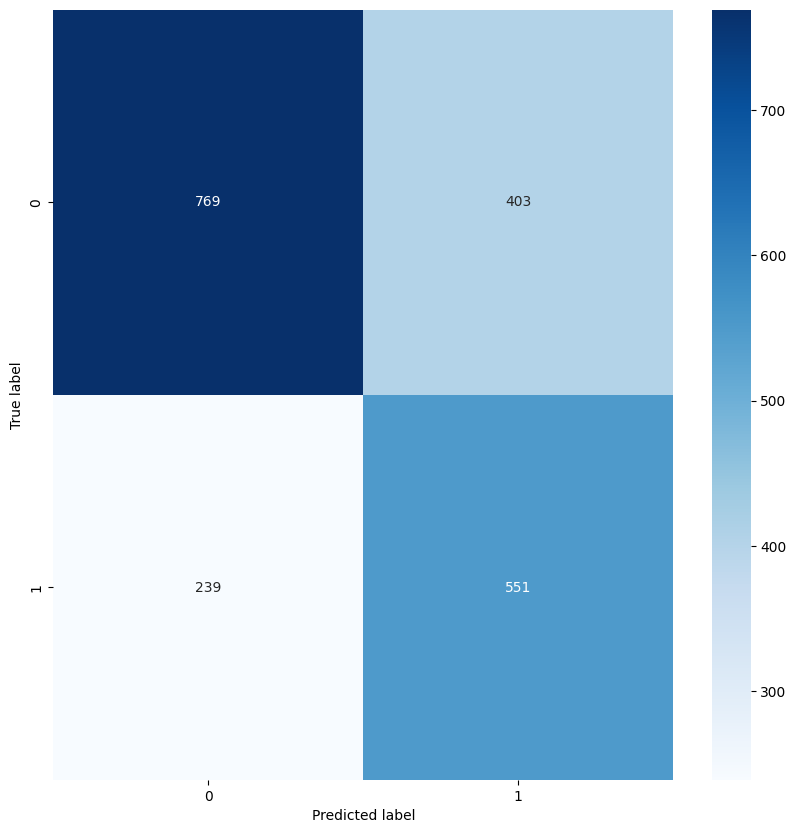

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(data_test.target, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()


# Decision Tree Classifier,

---



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Done in 29.988s
Best parameters combination found:
clf__max_depth: None
vect__max_df: 0.2
vect__min_df: 10
vect__ngram_range: (1, 2)
vect__norm: l2
Probabilities:
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
Predictions: ['S' 'C' 'C' ... 'S' 'S' 'C']
Accuracy on test set: 0.589
Mean Squared Error: 0.411
Classification report:
              precision    recall  f1-score   support

           C       0.68      0.60      0.64      1172
           S       0.49      0.57      0.53       790

    accuracy                           0.59      1962
   macro avg       0.58      0.59      0.58      1962
weighted avg       0.60      0.59      0.59      1962



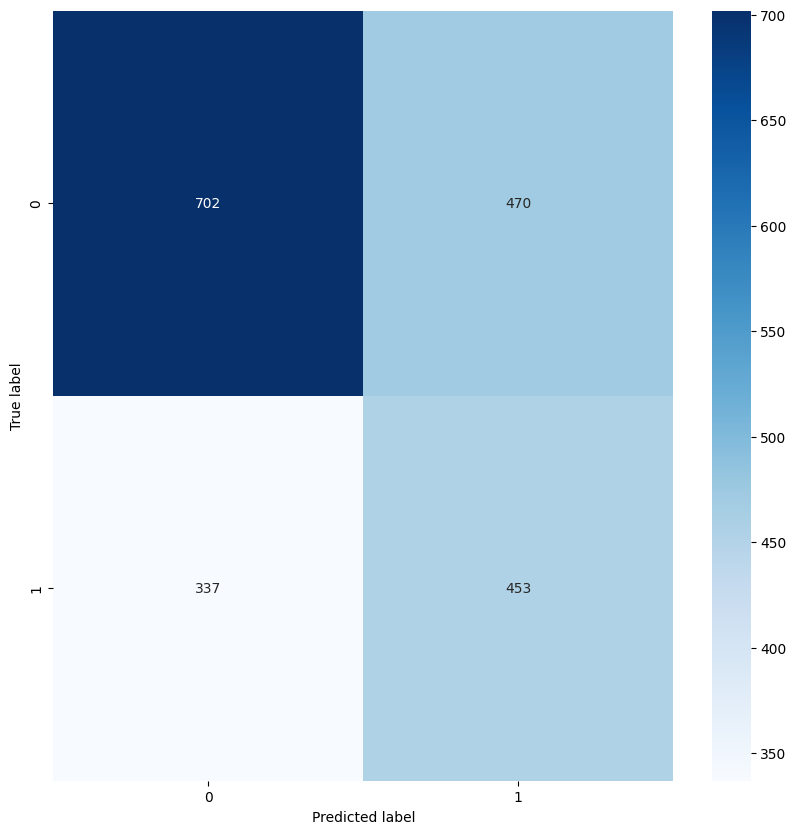

In [27]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelBinarizer
from time import time
import numpy as np


train_set = ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics']
test_set = [ 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']


# Fetch the training and testing data
data_train = fetch_20newsgroups(subset='train', categories=train_categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test', categories=test_categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))


category_mapping = {'comp.graphics':'C','comp.os.ms-windows.misc':'C','sci.crypt':'S','sci.electronics':'S',
                    'comp.sys.ibm.pc.hardware':'C','comp.sys.mac.hardware':'C','comp.windows.x':'C','sci.med':'S','sci.space':'S'}

data_train.target = [category_mapping[data_train.target_names[i]] for i in data_train.target]
data_test.target = [category_mapping[data_test.target_names[i]] for i in data_test.target]

# Define the pipeline with a TfidfVectorizer and DecisionTreeClassifier
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier()),
])

# Define the parameter grid for the RandomizedSearchCV
parameter_grid = {
    'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
    'vect__min_df': (1, 3, 5, 10),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__norm': ('l1', 'l2'),
    'clf__max_depth': [None, 10, 20, 30, 40, 50],
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameter_grid, n_iter=5, random_state=0, n_jobs=2, verbose=1)

# Fit the RandomizedSearchCV object to the training data
t0 = time()
random_search.fit(data_train.data, data_train.target)
print(f"Done in {time() - t0:.3f}s")

# Print the best parameters
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

# Calculate and print the probabilities
probabilities3 = random_search.predict_proba(data_test.data)
print("Probabilities:")
print(probabilities3)

# Predict the categories
predictions3 = random_search.predict(data_test.data)

# Print the predictions
print("Predictions:", predictions3)

# Calculate and print the accuracy on the test set
test_accuracy = random_search.score(data_test.data, data_test.target)
print(f"Accuracy on test set: {test_accuracy:.3f}")

# Print the mean squared error
# First, we need to convert the target labels to numeric values
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
numeric_test_target = le.fit_transform(data_test.target)
numeric_predictions = le.transform(random_search.predict(data_test.data))
mse = mean_squared_error(numeric_test_target, numeric_predictions)
print(f"Mean Squared Error: {mse:.3f}")

from sklearn.metrics import classification_report

# Calculate and print the precision, recall, and F1-score
predictions3 = random_search.predict(data_test.data)
report = classification_report(data_test.target, predictions3)
print("Classification report:")
print(report)

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(data_test.target, predictions3)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()


dtcmodel=random_search

# SMA (SIMPLE MODEL AVERAGING FRAMEWORK)

---



# The researchers have used this model only to compare its results with the results of the main LWE (locally weighted ensemble) algorithm, in order to show that the results of the locally weighted ensemble models are better than that of the globally weighted ensemble models.

In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
predictions1_i = le.fit_transform(predictions1)
predictions2_i = le.transform(predictions2)
predictions3_i = le.transform(predictions3)

# Combine the probabilities
combined_probabilities = (probabilities1 + probabilities2 + probabilities3) / 3

# Get the combined predictions
combined_predictions = np.argmax(combined_probabilities, axis=1)


data_test.target = le.transform(data_test.target)

# Calculate the accuracy
accuracy = accuracy_score(data_test.target, combined_predictions)
print(f"Accuracy: {accuracy}")

# Calculate the mean squared error
mse = mean_squared_error(data_test.target, combined_predictions)
print(f"Mean Squared Error: {mse}")


Accuracy: 0.6941896024464832
Mean Squared Error: 0.3058103975535168


# Reasoning for using Least Square Support Vector Machine(LS-SVM) instead of Transductive SVM (TSVM).

The reseachers have used Transductive SVM (TSVM) model to comapre its results with the results of LWE model, however even after multiple attempts i was unable to run the code for TSVM hence i have instead used LS-SVM model for comparison. LS-SVM and TSVM have both been previously used by researchers on the 20 newsgroup dataset as shown in the following research paper, hence i decided to go with the LS-SVM model.


Research Paper:

Saigal, P., & Khanna, V. (2020). Multi-category news classification using Support Vector Machine based classifiers. SN Applied Sciences, 2(3), 458.

https://link.springer.com/article/10.1007/s42452-020-2266-6

# Implementing LS-SVM model

---

Github Link for LS-SVM: https://github.com/DannyVanpoucke/LSSVMlib/blob/master/LSSVMlib/LSSVMRegression.py

In [29]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 19 09:27:21 2020

An LS-SVM regression class following the sk-learn API.

_                         _   _   _    _  _
| 0          1^T_N         |  | b  |   | 0 |
|                          |  |    | = |   |
| 1_N  Omega+gamma^-1 I_N  |  | a  |   | Y |
|_                        _|  |_  _|   |_ _|

Omega= Kernel K(x_i,x_j)
gamma= hyper-parameter (is a ratio z/µ with z the sum squared error and µ the
                        amount of regularization)
1_N = vector (1,1,1,..,1)
I_N = NxN unity matrix

@author: Dr. Dr. Danny E. P. Vanpoucke
@web   : https://dannyvanpoucke.be
"""
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin


class LSSVMRegression(BaseEstimator, RegressorMixin):
    """
    An Least Squared Support Vector Machine (LS-SVM) regression class, build
    on the BaseEstimator and RegressorMixin base classes of sklearn.
    (Let's hope furture upgrades of python sk-learn just doesn't break this...
    consider this a python feature)

    Attributes:
        - gamma : the hyper-parameter (float)
        - kernel: the kernel used     (string)
        - kernel_: the actual kernel function
        - x : the data on which the LSSVM is trained (call it support vectors)
        - y : the targets for the training data
        - coef_ : coefficents of the support vectors
        - intercept_ : intercept term

    """
    def __init__(self, gamma: float = 1.0, kernel: str = None, c: float = 1.0,
                 d: float = 2, sigma: float = 1.0):
        """
        Create a new regressor

        Parameters:
            - gamma: floating point value for the hyper-parameter gamma, DEFAULT=1.0
            - kernel: string indicating the kernel: {'linear','poly','rbf'}, DEFAULT='rbf'
            - the kernel parameters
                    * linear: none
                    * poly:
                        + c: scaling constant, DEFAULT=1.0
                        + d: polynomial power, DEFAULT=2
                    * rbf:
                        + sigma: scaling constant, DEFAULT=1.0
        """
        self.gamma = gamma
        self.c = c
        self.d = d
        self.sigma = sigma
        if kernel is None:
            self.kernel = 'rbf'
        else:
            self.kernel = kernel

        params = dict()
        if kernel == 'poly':
            params['c'] = c
            params['d'] = d
        elif kernel == 'rbf':
            params['sigma'] = sigma

        self.kernel_ = LSSVMRegression.__set_kernel(self.kernel, **params)

        #model parameters
        self.x = None
        self.y = None
        self.coef_ = None
        self.intercept_ = None

    def get_params(self, deep=True):
        """
            The get_params functionality provides the parameters of the LSSVMRegression class.
            These exclude the modelparameters.
        """
        return {"c": self.c, "d": self.d, "gamma": self.gamma,
                "kernel": self.kernel, "sigma":self.sigma}

    def set_params(self, **parameters):
        """
            Set the parameters of the class. Important note: This should do
            anything that is done to relevant parameters in __init__ as
            sklearn's GridSearchCV uses this instead of init.
            More info:  https://scikit-learn.org/stable/developers/develop.html
        """
        #print("SETTING PARAMETERS IN LSSVM:",parameters.items())

        for parameter, value in parameters.items():
            #setattr should do the trick for gamma,c,d,sigma and kernel
            setattr(self, parameter, value)
        #now also update the actual kernel
        params = dict()
        if self.kernel == 'poly':
            params['c'] = self.c
            params['d'] = self.d
        elif self.kernel == 'rbf':
            params['sigma'] = self.sigma
        self.kernel_ = LSSVMRegression.__set_kernel(self.kernel, **params)

        return self

    def set_attributes(self, **parameters):
        """
            Manually set the attributes of the model. This should generally
            not be done, except when testing some specific behaviour, or
            creating an averaged model.

            Parameters are provided as a dictionary.
                - 'intercept_' : float intercept
                - 'coef_'      : float array of coefficients
                - 'support_'   : array of support vectors, in the same order sorted
                                 as the coefficients
        """
        #not the most efficient way of doing it...but sufficient for the time being
        for param, value in parameters.items():
            if param == 'intercept_':
                self.intercept_ = value
            elif param == 'coef_':
                self.coef_ = value
            elif param == 'support_':
                self.x = value

    @staticmethod
    def __set_kernel(name: str, **params):
        """
            Internal static function to set the kernel function.
            NOTE: The second "vector" xj will be the one which generally
                  contains an array of possible vectors, while xi should be a single
                  vector. Therefore, the numpy dot-product requires xj to
                  be transposed.

            The kernel returns either a scalar or a numpy nd-array of
            rank 1 (i.e. a vector), if it returns something else the result
            is wrong if xi is an array.

        """
        def linear(xi, xj):
            """
               v*v=scal (dot-product OK)
               v*m=v    (dot-product OK)
               m*m=m    (matmul for 2Dx2D, ok with dot-product)
            """
            return np.dot(xi, xj.T)

        def poly(xi, xj, c=params.get('c', 1.0), d=params.get('d', 2)):
            """
                Polynomial kernel ={1+ (xi*xj^T)/c }^d

                Parameters:
                    - c: scaling constant, DEFAULT=1.0
                    - d: polynomial power, DEFAULT=2
                    - xi and xj are numpy nd-arrays
                (cf: https://en.wikipedia.org/wiki/Least-squares_support-vector_machine )

                works on same as linear
            """
            return ((np.dot(xi, xj.T))/c  + 1)**d

        def rbf(xi, xj, sigma=params.get('sigma', 1.0)):
            """
            Radial Basis Function kernel= exp(- ||xj-xi||² / (2*sigma²))
            In this formulation, the rbf is also known as the Gaussian kernel of variance sigma²
            As the Euclidean distance is strict positive, the results of this kernel
            are in the range [0..1] (x € [+infty..0])

            Parameters:
                - sigma: scaling constant, DEFAULT=1.0
                - xi and xj are numpy nd-arrays
            (cf: https://en.wikipedia.org/wiki/Least-squares_support-vector_machine )

            Possible combinations of xi and xj:
                vect & vect   -> scalar
                vect & array  -> vect
                array & array -> array => this one requires a pair distance...
                                    which can not be done with matmul and dot

                The vectors are the rows of the arrays (Arr[0,:]=first vect)

                The squared distance between vectors= sqr(sqrt( sum_i(vi-wi)² ))
                --> sqr & sqrt cancel
                --> you could use a dot-product operator for vectors...but this
                seems to fail for nd-arrays.

            For vectors:
                ||x-y||²=sum_i(x_i-y_i)²=sum_i(x²_i+y²_i-2x_iy_i)
                --> all products between vectors can be done via np.dot: takes the squares & sum

            For vector x and array of vectors y:
                --> x²_i : these are vectors: dot gives a scalar
                --> y²_i : this should be a list of scalars, one per vector.
                            => np.dot gives a 2d array
                            => so   1) square manually (squares each element)
                                    2) sum over every row (axis=1...but only in case we
                                                           have a 2D array)
                --> x_iy_i : this should also be a list of scalars. np.dot does the trick,
                            and even gives the same result if matrix and vector are exchanged

            for array of vectors x and array of vectors y:
                --> either loop over vectors of x, and for each do the above
                --> or use cdist which calculates the pairwise distance and use that in the exp

            """
            from scipy.spatial.distance import cdist

           # print('LS_SVM DEBUG: Sigma=',sigma,'  type=',type(sigma) )
           # print('              xi   =',xi,'  type=',type(xi))
           # print('              xj   =',xj,'  type=',type(xj))


            if (xi.ndim == 2 and xi.ndim == xj.ndim): # both are 2D matrices
                return np.exp(-(cdist(xi, xj, metric='sqeuclidean'))/(2*(sigma**2)))
            elif ((xi.ndim < 2) and (xj.ndim < 3)):
                ax = len(xj.shape)-1 #compensate for python zero-base
                return np.exp(-(np.dot(xi, xi) + (xj**2).sum(axis=ax)
                                - 2*np.dot(xi, xj.T))/(2*(sigma**2)))
            else:
                message = "The rbf kernel is not suited for arrays with rank >2"
                raise Exception(message)

        kernels = {'linear': linear, 'poly': poly, 'rbf': rbf}
        if kernels.get(name) is not None:
            return kernels[name]
        else: #unknown kernel: crash and burn?
            message = "Kernel "+name+" is not implemented. Please choose from : "
            message += str(list(kernels.keys())).strip('[]')
            raise KeyError(message)

    def __OptimizeParams(self):
        """
        Solve the matrix operation to get the coefficients.
        --> equation 3.5 and 3.6 of the book by Suykens
        ==> that is for classification, for regression slightly different cf Dilmen paper 2017

        self.y: 1D array
        self.X: 2D array (with rows the vectors: X[0,:] first vector)

        Set the class parameters:
            - self.intercept_ : intercept
            - self.coef_      : coefficients


        """
        #eq 3.6: Omega_kl = y_ky_lK(x_k,x_l)
        # !! note that the product of a vector and the transposed is a dot-product
        #    and we need an outer product
        #For classification and Regression, the matrices are slightly different...
        # (why? except for what came out of solving equations?
        # Dilmen et al, IFAC PapersOnline 50(1), 8642-8647 (2017))

        # Classification
        # Omega = np.multiply( np.multiply.outer(y,y), self.kernel_(X,X) ) # correct version
        #A_dag = np.linalg.pinv(np.block([
        #    [0,                           y.T                   ],
        #    [y,   Omega + self.gamma**-1 * np.eye(len(y_values))]
        #])) #need to check if the matrix is OK--> y.T parts
        #B = np.array([0]+[1]*len(y_values))

        #Regression
        Omega = self.kernel_(self.x, self.x)
        Ones = np.array([[1]]*len(self.y)) # needs to be a 2D 1-column vector, hence [[ ]]

        A_dag = np.linalg.pinv(np.block([
            [0,                           Ones.T                      ],
            [Ones,   Omega + self.gamma**-1 * np.identity(len(self.y))]
        ])) #need to check if the matrix is OK--> y.T parts
        B = np.concatenate((np.array([0]), self.y), axis=None)

        solution = np.dot(A_dag, B)
        self.intercept_ = solution[0]
        self.coef_      = solution[1:]


    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the parameters based on the support vectors X (and store these as they are
        parameters of the LS-SVM as well, because needed for prediction)

        We are doing Regression.
        Parameters:
            - X : 2D array of vectors (1 per row: X[0,:] first vector)
            - y : 1D vector of targets
        """

        #print("IN FIT==> GAMMA=",self.gamma,"  SIGMA=",self.sigma)

        if isinstance(X, (pd.DataFrame, pd.Series)): #checks if X is an instance of either types
            Xloc = X.to_numpy()
        else:
            Xloc = X

        if isinstance(y, (pd.DataFrame, pd.Series)):
            yloc = y.to_numpy()
        else:
            yloc = y

        #check the dimensionality of the input
        if (Xloc.ndim == 2) and (yloc.ndim == 1):
            self.x = Xloc
            self.y = yloc
            self.__OptimizeParams()
        else:
            message = "The fit procedure requires a 2D numpy array of features "\
                "and 1D array of targets"
            raise Exception(message)

    def predict(self, X: np.ndarray)->np.ndarray:
        """
        Predict the regression values for a set of feature vectors

        Parameters:
            - X: ndarray of feature vectors (max: 2D), 1 per row if more than one.

        """
        Ker = self.kernel_(X, self.x) #second component should be the array of training vectors
        Y = np.dot(self.coef_, Ker.T) + self.intercept_
        return Y

In [30]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Define the training and testing categories
training_categories = ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics']
testing_categories = [ 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']



# Fetch the training and testing datasets
newsgroups_train = fetch_20newsgroups(subset='train', categories=training_categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=testing_categories)

# Define the vectorizer and transform the data
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)

# Use TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
train_pca = svd.fit_transform(vectors_train)
test_pca = svd.transform(vectors_test)

# Define the labels for the two categories
labels_dict = {'C': 0, 'S': 1}

# Prepare the target values
y_train = np.array(list(map(lambda t: labels_dict['C'] if t < 2 else labels_dict['S'], newsgroups_train.target)))
y_test = np.array(list(map(lambda t: labels_dict['C'] if t < 3 else labels_dict['S'], newsgroups_test.target)))
print(y_test)

# Initialize the LS-SVM model
lssvm_model = LSSVMRegression(gamma=1.0, kernel='rbf')

# Train the LS-SVM model using the training data
lssvm_model.fit(train_pca, y_train)

# Make predictions on the testing data
predictions = lssvm_model.predict(test_pca)


[0 0 1 ... 0 1 0]


In [31]:
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

import numpy as np
print(predictions)
# Round the predictions and convert to integer type
predictions = np.round(predictions).astype(int)
print(predictions)

# Calculate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')






[0.5771711  0.44146084 0.37162282 ... 0.66537559 0.7891395  0.27306091]
[1 0 0 ... 1 1 0]
Accuracy: 0.7232415902140673
Mean Squared Error: 0.27675840978593275


# Following is the implementation of the Locally Weighted Ensemble (LWE) Algorithm.

---



# We implement LWE model in steps: There are two major steps in LWE algorithm which are:

# Step1: pLWE which is based only on Graph based weight estimation and does not consider Local Structure based adjustment

# Step2. Local Structure based adjustment





In **graph based weight estimation** the we construct two graphs Gt based on true class labels and Gm based on the corresponding models predictions for each base model(that is SVM, LR and RF), for all the test samples. Then we compare the similarity between the two graphs. The similarity is normalised in order to calculate the weights that will be assigned to each base model(that is SVM, LR and RF).

In **Local Structure based adjustment** step we first set a threshold which we have set at 0.5, meaning at least 50% of the edges between the two graphs Gm and Gt should be similar. Then we calculate the average similarity for each test sample that is s_avg. So if average similarity for a test sample is greater than 0.5 then the final prediction gotten from pLWE will be used for that test sample if not then we discard the prediction made by the pLWE model and consider a new unsupervised clustering model, (which in our case is K means Clustering) to make the predictions, the details of how the predictions are made given below in the implementation of Local structure based adjustment step.

# Implementing Step1: pLWE or Partial Locally Weighted Ensemble algorithm

---



Following is the implementation of the "partial locally weighted ensemble" algorithm which is basically "LWE" algorithm itself without the "Local Structure based adjustment" step.

In [32]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import SpectralClustering
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the training and testing categories
training_categories = ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics']
testing_categories = [ 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']

# Fetch the training and testing datasets
newsgroups_train = fetch_20newsgroups(subset='train', categories=training_categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=testing_categories)

# Define the vectorizer and transform the data
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)

# Use TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
train_pca = svd.fit_transform(vectors_train)
test_pca = svd.transform(vectors_test)

# Define the labels for the two categories manually
labels_dict = {'C': 0, 'S': 1}

# Map the labels to the target values
y_train = np.array([labels_dict[label] for label in ['C' if t < 2 else 'S' for t in newsgroups_train.target]])
y_test = np.array([labels_dict[label] for label in ['C' if t < 3 else 'S' for t in newsgroups_test.target]])

# Define the base models
svm_model = SVC(probability=True)
svm_model.fit(train_pca, y_train)

lr_model = LogisticRegression()
lr_model.fit(train_pca, y_train)

dtcmodel = DecisionTreeClassifier()
dtcmodel.fit(train_pca, y_train)

base_models = [svm_model, lr_model, dtcmodel]

# Define the number of clusters
num_clusters = 2

# Cluster the test examples
clustering = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
clusters = clustering.fit_predict(test_pca)

# Construct GT graph in which we cluster the test examples into 2 clusters as there are two categories R and T.
# then we connect two test examples with an edge if and only if the two examples are in the same cluster.
GT = np.zeros((len(test_pca), len(test_pca)))
for i in range(len(clusters)):
    for j in range(i+1, len(clusters)):
        if clusters[i] == clusters[j]:
            GT[i, j] = 1
            GT[j, i] = 1

# Construct GM for each model and calculate weights
similarity = np.zeros((len(base_models), len(test_pca)))
for m, model in enumerate(base_models):
    # Make predictions on the testing data
    probabilities = model.predict_proba(test_pca)
    predictions = probabilities.argmax(axis=1)

    # Construct GM, GM is a graph in which there is an edge connecting two test examples with an edge if and only if two examples are in the same cluster.
    GM = np.zeros((len(test_pca), len(test_pca)))
    for i in range(len(predictions)):
        for j in range(i+1, len(predictions)):
            if predictions[i] == predictions[j]:
                GM[i, j] = 1
                GM[j, i] = 1

    # Calculate weights
    for i in range(len(test_pca)):
        VM = np.where(GM[i] == 1)[0]
        VT = np.where(GT[i] == 1)[0]
        similarity[m, i] = len(np.intersect1d(VM, VT)) / (len(VM) + len(VT))

# Normalize weights
weights = similarity / np.sum(similarity, axis=0)
print(weights)

[[0.36269971 0.30068788 0.30068788 ... 0.34988279 0.36269971 0.30068788]
 [0.32570494 0.34280085 0.34280085 ... 0.31419532 0.32570494 0.34280085]
 [0.31159535 0.35651127 0.35651127 ... 0.33592189 0.31159535 0.35651127]]


In [33]:
print(weights.shape)#checking the shape of weight matrix

(3, 1962)


In [34]:
# Assuming weights is 2D numpy array of shape (3, 1423)
weight1 = weights[0:1, :]  # Extracts the first row
weight2 = weights[1:2, :]  # Extracts the second row
weight3 = weights[2:3, :]  # Extracts the third row

# Printing the shapes of the new matrices
print(weight1)
print("Shape of weight1:", weight1.shape)
print(weight2)
print("Shape of weight2:", weight2.shape)
print(weight3)
print("Shape of weight3:", weight3.shape)
print(type(weight3))


[[0.36269971 0.30068788 0.30068788 ... 0.34988279 0.36269971 0.30068788]]
Shape of weight1: (1, 1962)
[[0.32570494 0.34280085 0.34280085 ... 0.31419532 0.32570494 0.34280085]]
Shape of weight2: (1, 1962)
[[0.31159535 0.35651127 0.35651127 ... 0.33592189 0.31159535 0.35651127]]
Shape of weight3: (1, 1962)
<class 'numpy.ndarray'>


In [35]:
#just printing probabilities from the 3 base models that we implemented earlier.
print(probabilities1)
print(probabilities2)
print(probabilities3)


[[6.31166038e-02 9.36883396e-01]
 [9.93725883e-01 6.27411690e-03]
 [9.35601810e-01 6.43981905e-02]
 ...
 [1.36173474e-05 9.99986383e-01]
 [5.00573615e-07 9.99999499e-01]
 [9.84129579e-01 1.58704215e-02]]
[[4.55243815e-01 5.44756185e-01]
 [9.99594651e-01 4.05349377e-04]
 [9.90485406e-01 9.51459441e-03]
 ...
 [8.83515717e-06 9.99991165e-01]
 [3.16492461e-05 9.99968351e-01]
 [9.99999986e-01 1.35034647e-08]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [36]:
import numpy as np


# weight1 has shape (1, 1423)
# probabilities1 has shape (1423, 2)

# Reshape weight1 to match the shape of probabilities1
weight1_reshaped = weight1.reshape((1, -1))

# Perform element-wise multiplication
new_probabilities1 = probabilities1 * weight1_reshaped.T

# Printing the shape and the new array
print("Shape of new_probabilities1:", new_probabilities1.shape)
print("New probabilities1:", new_probabilities1)


# Reshape weight1 to match the shape of probabilities1
weight2_reshaped = weight2.reshape((1, -1))

# Perform element-wise multiplication
new_probabilities2 = probabilities2 * weight2_reshaped.T

# Printing the shape and the new array
print("Shape of new_probabilities2:", new_probabilities2.shape)
print("New probabilities2:", new_probabilities2)


# Reshape weight1 to match the shape of probabilities1
weight3_reshaped = weight3.reshape((1, -1))

# Perform element-wise multiplication
new_probabilities3 = probabilities3 * weight3_reshaped.T

# Printing the shape and the new array
print("Shape of new_probabilities3:", new_probabilities3.shape)
print("New probabilities3:", new_probabilities3)


Shape of new_probabilities1: (1962, 2)
New probabilities1: [[2.28923741e-02 3.39807340e-01]
 [2.98801327e-01 1.88655090e-03]
 [2.81324123e-01 1.93637552e-02]
 ...
 [4.76447548e-06 3.49878025e-01]
 [1.81557907e-07 3.62699532e-01]
 [2.95915834e-01 4.77204335e-03]]
Shape of new_probabilities2: (1962, 2)
New probabilities2: [[1.48275159e-01 1.77429780e-01]
 [3.42661896e-01 1.38954111e-04]
 [3.39539239e-01 3.26161105e-03]
 ...
 [2.77596503e-06 3.14192544e-01]
 [1.03083158e-05 3.25694631e-01]
 [3.42800845e-01 4.62899916e-09]]
Shape of new_probabilities3: (1962, 2)
New probabilities3: [[0.         0.31159535]
 [0.35651127 0.        ]
 [0.35651127 0.        ]
 ...
 [0.         0.33592189]
 [0.         0.31159535]
 [0.35651127 0.        ]]


In [37]:
import numpy as np

# Create the final_predictions matrix
final_probabilities = np.maximum.reduce([new_probabilities1, new_probabilities2, new_probabilities3])

# Printing the shape and the final predictions matrix
print("Shape of final_predictions:", final_probabilities.shape)
print("Final prrobabilities:", final_probabilities)


Shape of final_predictions: (1962, 2)
Final prrobabilities: [[1.48275159e-01 3.39807340e-01]
 [3.56511273e-01 1.88655090e-03]
 [3.56511273e-01 1.93637552e-02]
 ...
 [4.76447548e-06 3.49878025e-01]
 [1.03083158e-05 3.62699532e-01]
 [3.56511273e-01 4.77204335e-03]]


In [38]:
# Create final_predictions1 matrix
final_predictions1 = (final_probabilities[:, 0] < final_probabilities[:, 1]).astype(int)
#for example, if (final_predictions[:, 0] < final_predictions[:, 1]) then we get TRUE, which numerically means 1, which represents class T.

# Reshape final_predictions1 to match the desired shape
final_predictions1 = final_predictions1.reshape((1, -1))

# Printing the shape and the final_predictions1 matrix
print("Shape of final_predictions1:", final_predictions1.shape)
print("Final predictions1:", final_predictions1)


Shape of final_predictions1: (1, 1962)
Final predictions1: [[1 0 0 ... 1 1 0]]


In [39]:
# Reshape final_predictions1 to match the shape of y_test
final_predictions1 = final_predictions1.reshape(-1)
print(final_predictions1)
print(final_predictions1.shape)



[1 0 0 ... 1 1 0]
(1962,)


In [40]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, final_predictions1)
print("Accuracy:", accuracy)

# Calculate the mean squared error
mse = mean_squared_error(y_test, final_predictions1)
print("Mean Squared Error:", mse)


Accuracy: 0.6381243628950051
Mean Squared Error: 0.36187563710499493


# END OF pLWE



---
# after implementing pLWE we implement the Local Structure based adjustment step, then the LWE algorithm is complete and we get the final predictions.


---
# Implementing the Local Structure Based Adjustment step


1. In **Local Structure based adjustment** step we first set a threshold which we have set at 0.5, meaning at least 50% of the edges between the two graphs Gm and Gt should be similar. Then we calculate the average similarity for each test sample that is s_avg.
2. So if average similarity for a test sample is greater than 0.5 then the final prediction gotten from pLWE will be used for that test sample if not then we discard the prediction made by the pLWE model and consider a new unsupervised clustering model, (which in our case is K means Clustering) to make the predictions.

3. K means clustering has been used because the research paper mentions Unsupervised algorithm for clustering that is based on neighbours of x, although KNN would be a more appropriate choice for this but since it doesnt form clusters i decided to go with K means clustering algorithm.


4. Now all the test samples that have s_avg less than 0.5, are clustered using K means clustering and separated into different 4 different test clusters. 4 test clusters becuase there are 4 sub categories in the test data.

5. Now after test clusters are formed, reliable clusters are made that contain test samples for which the s_avg is greater than 0.35.

6. Now we calculate the final probability for a test sample x belonging to say class 0, by dividing the no of reliable samples that also have class label 0, in that cluster to which x belongs, divided by the the total number of test samples in that particular cluster.


for example let us say test example x belongs to cluster c, then
probability that x belongs to class 0 =(no of reliable samples in cluster c with label 0/ total number of test samples in cluster C.)

**for no. of clusters equal to 4, implementing local structure based adjustment step:**

Reference: Clustering text document using K means
https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [59]:


# Calculate the average similarity for all test examples
s_avg = np.mean(similarity, axis=0)
print(s_avg)

# Initialize the final probabilities
final_probabilities = np.zeros((len(test_pca), 2))


[0.33446514 0.32669353 0.32669353 ... 0.34671729 0.33446514 0.32669353]


In [60]:
# Define the threshold
threshold = 0.34

# Calculate the average similarity
s_avg = np.mean(similarity, axis=0)
print("Average Similarity:", s_avg)

# Find the indices where s_avg is greater than the threshold
indices_above_threshold = np.where(s_avg > threshold)[0]


# Count the number of points with s_avg > 0.34
num_points_above_threshold = len(indices_above_threshold)
print(f"\nNumber of points with s_avg > 0.34: {num_points_above_threshold}")


Average Similarity: [0.33446514 0.32669353 0.32669353 ... 0.34671729 0.33446514 0.32669353]

Number of points with s_avg > 0.34: 353


In [61]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Define the categories for the training and testing datasets
training_categories = ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics']
testing_categories = [ 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']


# Fetch the training dataset
training_dataset = fetch_20newsgroups(subset='train', categories=training_categories, shuffle=True, random_state=42)

# Fetch the testing dataset
testing_dataset = fetch_20newsgroups(subset='test', categories=testing_categories, shuffle=True, random_state=42)

# Vectorize the training dataset
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(training_dataset.data)

# Train the KMeans model
kmeans = KMeans(n_clusters=len(training_categories), max_iter=100, n_init=1, random_state=42)
kmeans.fit(X_train)


# Vectorize the testing dataset using the same vectorizer
X_test = vectorizer.transform(testing_dataset.data)

# Use the trained model to get clusters for the testing dataset
test_clusters = kmeans.predict(X_test)

# Print the clusters
for i, cluster in enumerate(test_clusters):
    print(f"Document {i} is assigned to cluster {cluster}")


Document 0 is assigned to cluster 0
Document 1 is assigned to cluster 2
Document 2 is assigned to cluster 2
Document 3 is assigned to cluster 2
Document 4 is assigned to cluster 2
Document 5 is assigned to cluster 2
Document 6 is assigned to cluster 2
Document 7 is assigned to cluster 2
Document 8 is assigned to cluster 2
Document 9 is assigned to cluster 1
Document 10 is assigned to cluster 2
Document 11 is assigned to cluster 1
Document 12 is assigned to cluster 2
Document 13 is assigned to cluster 2
Document 14 is assigned to cluster 2
Document 15 is assigned to cluster 1
Document 16 is assigned to cluster 2
Document 17 is assigned to cluster 2
Document 18 is assigned to cluster 2
Document 19 is assigned to cluster 1
Document 20 is assigned to cluster 1
Document 21 is assigned to cluster 1
Document 22 is assigned to cluster 2
Document 23 is assigned to cluster 2
Document 24 is assigned to cluster 2
Document 25 is assigned to cluster 2
Document 26 is assigned to cluster 2
Document 27

In [62]:
test_clusters

array([0, 2, 2, ..., 2, 2, 2], dtype=int32)

In [63]:
print(test_clusters.shape)

(1962,)


In [64]:
# Initialize the clusters
test_cluster0, test_cluster1, test_cluster2, test_cluster3 = [], [], [], []
reliable_cluster0, reliable_cluster1, reliable_cluster2, reliable_cluster3 = [], [], [], []

# forming test clusters and reliable clusters:

for i, cluster in enumerate(test_clusters):
    if cluster == 0:
        test_cluster0.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster0.append(i)
    elif cluster == 1:
        test_cluster1.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster1.append(i)
    elif cluster == 2:
        test_cluster2.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster2.append(i)
    elif cluster == 3:
        test_cluster3.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster3.append(i)


In [65]:
print(test_cluster0)
print(test_cluster1)
print(test_cluster2)
print(reliable_cluster0)
print(reliable_cluster1)

[0, 49, 135, 165, 268, 333, 437, 450, 454, 497, 499, 503, 556, 574, 583, 585, 646, 680, 759, 762, 781, 818, 830, 869, 877, 905, 914, 940, 957, 1097, 1127, 1211, 1215, 1224, 1229, 1267, 1432, 1441, 1539, 1550, 1558, 1623, 1632, 1671, 1675, 1708, 1724, 1785, 1845, 1850, 1912, 1917]
[9, 11, 15, 19, 20, 21, 28, 62, 88, 116, 136, 141, 149, 159, 170, 185, 203, 212, 216, 218, 241, 265, 309, 324, 363, 369, 378, 406, 414, 488, 489, 500, 518, 536, 541, 554, 623, 643, 662, 669, 674, 686, 755, 757, 769, 788, 837, 839, 840, 873, 886, 897, 928, 941, 946, 950, 1007, 1024, 1053, 1056, 1059, 1062, 1065, 1094, 1109, 1135, 1171, 1186, 1190, 1197, 1204, 1209, 1221, 1265, 1276, 1301, 1312, 1342, 1356, 1365, 1384, 1412, 1416, 1422, 1424, 1440, 1479, 1481, 1484, 1488, 1502, 1513, 1514, 1527, 1568, 1613, 1626, 1649, 1661, 1734, 1742, 1743, 1749, 1755, 1758, 1787, 1800, 1802, 1803, 1815, 1837, 1848, 1851, 1863, 1948, 1957]
[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 29, 30, 31,

In [66]:
# Initialize the final probabilities
final_probabilities = np.zeros((len(testing_dataset.data), 2))

# Iterate over each test sample
for i, test_sample in enumerate(testing_dataset.data):
    # Check if the s_avg for the test sample is less than 0.5
    if s_avg[i] < 0.5:
        # Calculate the probabilities for each cluster
        if i in test_cluster3:
            print("samples in cluster3",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster3] == 0)) / (len(reliable_cluster3))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster3] == 1)) / (len(reliable_cluster3))
            print("probablity after 3",final_probabilities)
        elif i in test_cluster1:
            print("samples in cluster1",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster1] == 0)) / (len(reliable_cluster1))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster1] == 1)) / (len(reliable_cluster1))
            print("probablity after 1",final_probabilities)
        elif i in test_cluster2:
            print("samples in cluster2",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster2] == 0)) / (len(reliable_cluster2))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster2] == 1)) / (len(reliable_cluster2))
            print("probablity after 2",final_probabilities)
        elif i in test_cluster0:
            print("samples in cluster0",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster0] == 0)) / (len(reliable_cluster0))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster0] == 1)) / (len(reliable_cluster0))
            print("probablity after 0",final_probabilities)

    else:
      print("print final prediction for i", final_predictions1[i])

# Calculate the final predictions
new_final_predictions = np.argmax(final_probabilities, axis=1)

# Print the final predictions
print("new Final predictions1:", new_final_predictions)


samples in cluster0 0
probablity after 0 [[0.75 0.25]
 [0.   0.  ]
 [0.   0.  ]
 ...
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]]
samples in cluster2 1
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.38040346]
 [0.         0.        ]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 2
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.38040346]
 [0.61959654 0.38040346]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 3
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.38040346]
 [0.61959654 0.38040346]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 4
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.38040346]
 [0.61959654 0.38040346]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 5
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.380403

<ipython-input-66-b4ad150fca61>:11: RuntimeWarning: invalid value encountered in scalar divide
  final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster3] == 0)) / (len(reliable_cluster3))
<ipython-input-66-b4ad150fca61>:12: RuntimeWarning: invalid value encountered in scalar divide
  final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster3] == 1)) / (len(reliable_cluster3))


Streaming output truncated to the last 5000 lines.
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.38040346]
 [0.61959654 0.38040346]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 1338
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.38040346]
 [0.61959654 0.38040346]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 1339
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.38040346]
 [0.61959654 0.38040346]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 1340
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.38040346]
 [0.61959654 0.38040346]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 1341
probablity after 2 [[0.75       0.25      ]
 [0.61959654 0.38040346]
 [0.61959654 0.38040346]
 ...
 [0.         0.        ]
 [0.         0.        ]


In [67]:
print("final predictions:", new_final_predictions)
print(new_final_predictions.shape)

final predictions: [0 0 0 ... 0 0 0]
(1962,)


In [68]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, new_final_predictions)
print("Accuracy:", accuracy)

# Calculate the mean squared error
mse = mean_squared_error(y_test, new_final_predictions)
print("Mean Squared Error:", mse)

Accuracy: 0.5973496432212029
Mean Squared Error: 0.4026503567787971




The difference in the results could be because of the following reasons:
1. The researchers have used a software called CLUTO for clustering the test samples which can influence the results, whereas I have used K means clustering.
2. I have taken number of clusters as 4 because there are 4 different sub categories in the test_data, however the researchers have mentioned that the best performance is obtained when the number of clusters are 2.

# The researchers have mentioned that the highest accuracy is obtained when threshold is kept at 0.5 and the Number of clusters is equal to 2, hence let us check the performance at number of clusters equal to 2.

# finding accuracy and mse if number of clusters is equal to 2:

In [69]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Define the categories for the training and testing datasets
training_categories = ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics']
testing_categories = [ 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']

# Fetch the training dataset
training_dataset = fetch_20newsgroups(subset='train', categories=training_categories, shuffle=True, random_state=42)

# Fetch the testing dataset
testing_dataset = fetch_20newsgroups(subset='test', categories=testing_categories, shuffle=True, random_state=42)

# Vectorize the training dataset
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(training_dataset.data)

# Train the KMeans model
#kmeans = KMeans(n_clusters=len(training_categories), max_iter=100, n_init=1, random_state=42)
#kmeans.fit(X_train)
kmeans = KMeans(n_clusters=2, max_iter=100, n_init=1, random_state=42)
kmeans.fit(X_train)

# Vectorize the testing dataset using the same vectorizer
X_test = vectorizer.transform(testing_dataset.data)

# Use the trained model to get clusters for the testing dataset
test_clusters = kmeans.predict(X_test)

# Print the clusters
for i, cluster in enumerate(test_clusters):
    print(f"Document {i} is assigned to cluster {cluster}")


Document 0 is assigned to cluster 1
Document 1 is assigned to cluster 1
Document 2 is assigned to cluster 1
Document 3 is assigned to cluster 1
Document 4 is assigned to cluster 1
Document 5 is assigned to cluster 1
Document 6 is assigned to cluster 1
Document 7 is assigned to cluster 1
Document 8 is assigned to cluster 1
Document 9 is assigned to cluster 1
Document 10 is assigned to cluster 1
Document 11 is assigned to cluster 1
Document 12 is assigned to cluster 1
Document 13 is assigned to cluster 1
Document 14 is assigned to cluster 1
Document 15 is assigned to cluster 1
Document 16 is assigned to cluster 1
Document 17 is assigned to cluster 1
Document 18 is assigned to cluster 1
Document 19 is assigned to cluster 1
Document 20 is assigned to cluster 1
Document 21 is assigned to cluster 1
Document 22 is assigned to cluster 1
Document 23 is assigned to cluster 1
Document 24 is assigned to cluster 1
Document 25 is assigned to cluster 1
Document 26 is assigned to cluster 1
Document 27

In [70]:

test_cluster0, test_cluster1= [], []
reliable_cluster0, reliable_cluster1 = [], []

# forming test clusters and reliable clusters:

for i, cluster in enumerate(test_clusters):
    if cluster == 0:
        test_cluster0.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster0.append(i)
    else:
        test_cluster1.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster1.append(i)


In [71]:
# Initialize the final probabilities
final_probabilities = np.zeros((len(testing_dataset.data), 2))

# Iterate over each test sample
for i, test_sample in enumerate(testing_dataset.data):
    # Check if the s_avg for the test sample is less than 0.5
    if s_avg[i] < 0.5:
        # Calculate the probabilities for each cluster
        if i in test_cluster0:
            print("samples in cluster",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster0] == 0)) / (len(reliable_cluster0))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster0] == 1)) / (len(reliable_cluster0))
            print("probablity after 3",final_probabilities)
        else:
            print("samples in cluster1",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster1] == 0)) / (len(reliable_cluster1))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster1] == 1)) / (len(reliable_cluster1))
            print("probablity after 1",final_probabilities)


    else:
      print("print final prediction for i", final_predictions1[i])

# Calculate the final predictions
new_final_predictions = np.argmax(final_probabilities, axis=1)

# Print the final predictions
print("new Final predictions1:", new_final_predictions)


samples in cluster1 0
probablity after 1 [[0.62322946 0.37677054]
 [0.         0.        ]
 [0.         0.        ]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster1 1
probablity after 1 [[0.62322946 0.37677054]
 [0.62322946 0.37677054]
 [0.         0.        ]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster1 2
probablity after 1 [[0.62322946 0.37677054]
 [0.62322946 0.37677054]
 [0.62322946 0.37677054]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster1 3
probablity after 1 [[0.62322946 0.37677054]
 [0.62322946 0.37677054]
 [0.62322946 0.37677054]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster1 4
probablity after 1 [[0.62322946 0.37677054]
 [0.62322946 0.37677054]
 [0.62322946 0.37677054]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in clus

<ipython-input-71-4ae1788c4ad2>:11: RuntimeWarning: invalid value encountered in scalar divide
  final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster0] == 0)) / (len(reliable_cluster0))
<ipython-input-71-4ae1788c4ad2>:12: RuntimeWarning: invalid value encountered in scalar divide
  final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster0] == 1)) / (len(reliable_cluster0))


Streaming output truncated to the last 5000 lines.
probablity after 1 [[0.62322946 0.37677054]
 [0.62322946 0.37677054]
 [0.62322946 0.37677054]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster1 1338
probablity after 1 [[0.62322946 0.37677054]
 [0.62322946 0.37677054]
 [0.62322946 0.37677054]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster1 1339
probablity after 1 [[0.62322946 0.37677054]
 [0.62322946 0.37677054]
 [0.62322946 0.37677054]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster1 1340
probablity after 1 [[0.62322946 0.37677054]
 [0.62322946 0.37677054]
 [0.62322946 0.37677054]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster1 1341
probablity after 1 [[0.62322946 0.37677054]
 [0.62322946 0.37677054]
 [0.62322946 0.37677054]
 ...
 [0.         0.        ]
 [0.         0.        ]


In [72]:
# Calculate the accuracy
accuracy02 = accuracy_score(y_test, new_final_predictions)
print("Accuracy:", accuracy02)

# Calculate the mean squared error
mse02 = mean_squared_error(y_test, new_final_predictions)
print("Mean Squared Error:", mse02)

Accuracy: 0.5973496432212029
Mean Squared Error: 0.4026503567787971


The accuracy and mse of LWE model of LWE model for no of cluster equal to 2 is 0.4026 and 0.5973 respectively.

# trying for no of cluster = 6

In [73]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Define the categories for the training and testing datasets
training_categories = ['comp.graphics','comp.os.ms-windows.misc','sci.crypt','sci.electronics']
testing_categories = [ 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','sci.med','sci.space']

# Fetch the training dataset
training_dataset = fetch_20newsgroups(subset='train', categories=training_categories, shuffle=True, random_state=42)

# Fetch the testing dataset
testing_dataset = fetch_20newsgroups(subset='test', categories=testing_categories, shuffle=True, random_state=42)

# Vectorize the training dataset
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(training_dataset.data)

# Train the KMeans model
#kmeans = KMeans(n_clusters=len(training_categories), max_iter=100, n_init=1, random_state=42)
#kmeans.fit(X_train)
kmeans = KMeans(n_clusters=6, max_iter=100, n_init=1, random_state=42)
kmeans.fit(X_train)

# Vectorize the testing dataset using the same vectorizer
X_test = vectorizer.transform(testing_dataset.data)

# Use the trained model to get clusters for the testing dataset
test_clusters = kmeans.predict(X_test)

# Print the clusters
for i, cluster in enumerate(test_clusters):
    print(f"Document {i} is assigned to cluster {cluster}")


Document 0 is assigned to cluster 2
Document 1 is assigned to cluster 2
Document 2 is assigned to cluster 2
Document 3 is assigned to cluster 2
Document 4 is assigned to cluster 2
Document 5 is assigned to cluster 2
Document 6 is assigned to cluster 2
Document 7 is assigned to cluster 2
Document 8 is assigned to cluster 2
Document 9 is assigned to cluster 1
Document 10 is assigned to cluster 2
Document 11 is assigned to cluster 1
Document 12 is assigned to cluster 2
Document 13 is assigned to cluster 2
Document 14 is assigned to cluster 2
Document 15 is assigned to cluster 1
Document 16 is assigned to cluster 0
Document 17 is assigned to cluster 2
Document 18 is assigned to cluster 2
Document 19 is assigned to cluster 1
Document 20 is assigned to cluster 1
Document 21 is assigned to cluster 1
Document 22 is assigned to cluster 2
Document 23 is assigned to cluster 2
Document 24 is assigned to cluster 2
Document 25 is assigned to cluster 2
Document 26 is assigned to cluster 2
Document 27

In [74]:
# Initialize the clusters
test_cluster0, test_cluster1, test_cluster2, test_cluster3, test_cluster4, test_cluster5 = [], [], [], [], [], []
reliable_cluster0, reliable_cluster1, reliable_cluster2, reliable_cluster3, reliable_cluster4, reliable_cluster5 = [], [], [], [], [], []

# forming test clusters and reliable clusters:

for i, cluster in enumerate(test_clusters):
    if cluster == 0:
        test_cluster0.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster0.append(i)
    elif cluster == 1:
        test_cluster1.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster1.append(i)
    elif cluster == 2:
        test_cluster2.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster2.append(i)
    elif cluster == 3:
        test_cluster3.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster3.append(i)
    elif cluster == 4:
        test_cluster4.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster4.append(i)
    elif cluster == 5:
        test_cluster5.append(i)
        if s_avg[i] >= 0.34:
            reliable_cluster5.append(i)


In [75]:
# Initialize the final probabilities
final_probabilities = np.zeros((len(testing_dataset.data), 2))

# Iterate over each test sample
for i, test_sample in enumerate(testing_dataset.data):
    # Check if the s_avg for the test sample is less than 0.5
    if s_avg[i] < 0.5:
        # Calculate the probabilities for each cluster
        if i in test_cluster3:
            print("samples in cluster3",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster3] == 0)) / (len(reliable_cluster3))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster3] == 1)) / (len(reliable_cluster3))
            print("probablity after 3",final_probabilities)
        elif i in test_cluster1:
            print("samples in cluster1",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster1] == 0)) / (len(reliable_cluster1))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster1] == 1)) / (len(reliable_cluster1))
            print("probablity after 1",final_probabilities)
        elif i in test_cluster2:
            print("samples in cluster2",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster2] == 0)) / (len(reliable_cluster2))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster2] == 1)) / (len(reliable_cluster2))
            print("probablity after 2",final_probabilities)
        elif i in test_cluster0:
            print("samples in cluster0",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster0] == 0)) / (len(reliable_cluster0))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster0] == 1)) / (len(reliable_cluster0))
            print("probablity after 0",final_probabilities)
        elif i in test_cluster4:
            print("samples in cluster0",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster4] == 0)) / (len(reliable_cluster4))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster4] == 1)) / (len(reliable_cluster4))
            print("probablity after 0",final_probabilities)
        elif i in test_cluster5:
            print("samples in cluster0",i)
            final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster5] == 0)) / (len(reliable_cluster5))
            final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster5] == 1)) / (len(reliable_cluster5))
            print("probablity after 0",final_probabilities)

    else:
      print("print final prediction for i", final_predictions1[i])

# Calculate the final predictions
new_final_predictions6 = np.argmax(final_probabilities, axis=1)

# Print the final predictions
print("new Final predictions1:", new_final_predictions6)


samples in cluster2 0
probablity after 2 [[0.62130178 0.37869822]
 [0.         0.        ]
 [0.         0.        ]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 1
probablity after 2 [[0.62130178 0.37869822]
 [0.62130178 0.37869822]
 [0.         0.        ]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 2
probablity after 2 [[0.62130178 0.37869822]
 [0.62130178 0.37869822]
 [0.62130178 0.37869822]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 3
probablity after 2 [[0.62130178 0.37869822]
 [0.62130178 0.37869822]
 [0.62130178 0.37869822]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 4
probablity after 2 [[0.62130178 0.37869822]
 [0.62130178 0.37869822]
 [0.62130178 0.37869822]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in clus

<ipython-input-75-c6c4b859b068>:36: RuntimeWarning: invalid value encountered in scalar divide
  final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster5] == 0)) / (len(reliable_cluster5))
<ipython-input-75-c6c4b859b068>:37: RuntimeWarning: invalid value encountered in scalar divide
  final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster5] == 1)) / (len(reliable_cluster5))


Streaming output truncated to the last 5000 lines.
probablity after 2 [[0.62130178 0.37869822]
 [0.62130178 0.37869822]
 [0.62130178 0.37869822]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 1338
probablity after 2 [[0.62130178 0.37869822]
 [0.62130178 0.37869822]
 [0.62130178 0.37869822]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 1339
probablity after 2 [[0.62130178 0.37869822]
 [0.62130178 0.37869822]
 [0.62130178 0.37869822]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 1340
probablity after 2 [[0.62130178 0.37869822]
 [0.62130178 0.37869822]
 [0.62130178 0.37869822]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
samples in cluster2 1341
probablity after 2 [[0.62130178 0.37869822]
 [0.62130178 0.37869822]
 [0.62130178 0.37869822]
 ...
 [0.         0.        ]
 [0.         0.        ]


<ipython-input-75-c6c4b859b068>:11: RuntimeWarning: invalid value encountered in scalar divide
  final_probabilities[i, 0] = (np.sum(y_test[reliable_cluster3] == 0)) / (len(reliable_cluster3))
<ipython-input-75-c6c4b859b068>:12: RuntimeWarning: invalid value encountered in scalar divide
  final_probabilities[i, 1] = (np.sum(y_test[reliable_cluster3] == 1)) / (len(reliable_cluster3))


In [76]:
# Calculate the accuracy
accuracy6 = accuracy_score(y_test, new_final_predictions6)
print("Accuracy:", accuracy6)

# Calculate the mean squared error
mse6 = mean_squared_error(y_test, new_final_predictions6)
print("Mean Squared Error:", mse6)

Accuracy: 0.5973496432212029
Mean Squared Error: 0.4026503567787971


# CONCLUSION

---



# 1. Hence I checked the performance of the LWE algorithm at no. of clusters equal to 2, 4 and 6. The accuracy and MSE is same for all three cases.(at threshold for s_avg=0.5 and threshold for reliable indices as 0.34).

# 2.  In the research paper they have obtained highest accuracy at the no of clusters equal to 2 and threshold equal to 0.5.

# 3. The details of why there is a  difference in results shall be mentioned in the report and presentation.

# References:

1. C. G. Atkeson, A. W. Moore, and S. Schaal. Locally
weighted learning. Artificial Intelligence Review,
11(1-5):11–73, 1997

2. A. Genkin, D. D. Lewis, and D. Madigan. Bbr: Bayesian
logistic regression software.
http://stat.rutgers.edu/~madigan/BBR/


3. J. Huang, A. J. Smola, A. Gretton, K. M. Borgwardt, and
B. Sch¨olkopf. Correcting sample selection bias by unlabeled
data. In Proc. of NIPS’ 06, pages 601–608. 2007

4. Saigal, P., & Khanna, V. (2020). Multi-category news classification using support vector machine based classifiers. SN Applied Sciences, 2(3), 458.

5. Github Link for LS-SVM: https://github.com/DannyVanpoucke/LSSVMlib/blob/master/LSSVMlib/LSSVMRegression.py



6. Scikit Learn link for Sparse Logistic Regression: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_20newsgroups.html



7. Github link for TSVM: https://github.com/tmadl/semisup-learn/blob/master/methods/qns3vm.py

8. Sample pipeline for text feature extraction and evaluation:
 https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-plot-grid-search-text-feature-extraction-py

 https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
